# Groupe 4: Etude du parcours d'engagement à l'application diapason

Diapason est une application qui s'adresse aux personnes souffrant d'acouphènes. Elle a pour vocation de proposer à ses utilisateurs un diagnostic puis des thérapies adaptées pour réduire l'inconfort engendré par les acouphènes. Cette application propose deux modes de fonctionnement. Le premier est gratuit et permet simplement d'obtenir un diagnostic et obtenir des informations sur les acouphènes. Le second est lui payant, l'utilisateur achète un abonnement à 150€/an et il a accès à plusieurs type de thérapies et d'exercice à effectuer quotidiennement.

Nous avons voulu nous intéresser au parcours d'engagement. Plus précisément, nous avons cherché à comprendre quel type d'utilisateur achetait la license et pourquoi? 
Pour ce faire nous avons étudié et comparé, sur plusieurs critères, les utilisateurs et les utilisateurs licenciés (c'est à dire ayant payé l'abonnement.

Notre étude se divise en 2 parties: 

### I/ Etude et analyse des variables

### II/ Catégorisation des utilisateurs licenciés

### Import des bibliothèques utiles et des données

In [1]:
import pymongo # conda install pymongo
from datetime import datetime
from pprint import pprint as prettyprint
import matplotlib.pyplot as plt
#import databases as db
import pandas as pd
import seaborn as sns
import statistics as stat
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

C:\Users\tomjc\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
### Inits & retrieve of DB and collections
client = pymongo.MongoClient()  # will connect to default local DB - should be enough for the course.

csdiapason_db = client['csdiapason']  # selecting database.

events_collection = csdiapason_db['events']
licenses_collection = csdiapason_db['licenses']
states_collection = csdiapason_db['states']
users_collection = csdiapason_db['users']

# I/ Analyse des variables

Dans cette première partie nous allons étudier différents paramètres comme: l'âge des utilisateurs, la langue de leur téléphone, le type de téléphone, le type de système d'exploitation, le prix du téléphone...

## 1. Age des utilisateurs

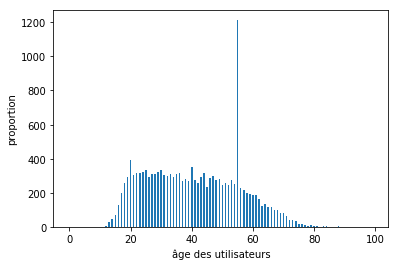

In [10]:
# on regarde les utilisateurs en fonction de leur age
liste_ages=[]
for i in range (100): #On représente ici le graphique sans prendre en compte la valeur par défaut de la date de naissance
    n=2020-i
    n_naissance = users_collection.count_documents(filter={
        'birthDate' : { 
            '$gte': datetime(n,1,1,0,0,0), 
            '$lte': datetime(n,12,31,23,59,59)
        }
            }) 
    liste_ages.append(n_naissance)

ages= range(0,100)
plt.bar(ages,liste_ages,0.5)
plt.xlabel('âge des utilisateurs')
plt.ylabel('proportion')
plt.show()

On constate un pic au niveau de 55ans. Ce pic est invraisemblable au vu du reste de la distribution. En réalité, il s'agit des utilisateurs ayant laissé la date de naissance par défaut. Nous avons donc fait le choix de retirer les utilisateurs étant né en 1965 en considérant que cela n'altererait pas le reste des données. 

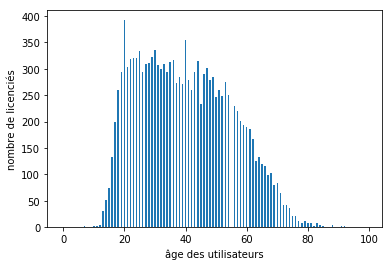

In [4]:
# on regarde le nombre de licenciés en fonction de l'age
liste_ages2=[]
for i in range (100): #La valeur par défaut est prise en compte
    n=2020-i
    if n!=1965:
        
        n_naissance = users_collection.count_documents(filter={
        'birthDate' : { 
            '$gte': datetime(n,1,1,0,0,0), 
            '$lte': datetime(n,12,31,23,59,59)
        }
            })
    else: 
        n_naissance=0
    liste_ages2.append(n_naissance)
ages=range(0,100)
plt.bar(ages,liste_ages2,0.5)
plt.xlabel('âge des utilisateurs')
plt.ylabel('nombre de licenciés')
plt.show()

Ici on observe une nouvelle répartition des utilisateurs qui est plus cohérente.

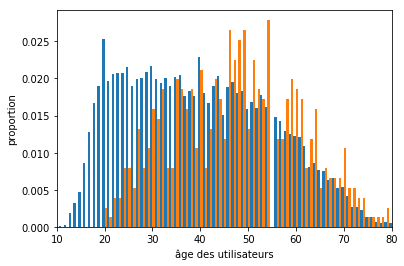

In [5]:

liste_ages2=[]
for i in range (100): #La valeur par défaut est prise en compte
    n=2020-i
    if n!=1965:
        
        n_naissance = users_collection.count_documents(filter={
        'birthDate' : { 
            '$gte': datetime(n,1,1,0,0,0), 
            '$lte': datetime(n,12,31,23,59,59)
        }
            })
    else: 
        n_naissance=0
    liste_ages2.append(n_naissance)
ages=range(0,100)





liste_ageslicences=[]
for i in range (100):
    n=2020-i
    res=0
    if n==1965:
        res=0
    else:
        date_naissance =licenses_collection.aggregate(pipeline=[
        {
            '$lookup': {
                'from': 'users',
                'localField': 'user',
                'foreignField': '_id',
                'as': 'user_document'
            }
        },
        {
            '$match': {
                'user_document.birthDate' : {'$gte': datetime(n,1,1,0,0,0), 
                                '$lte': datetime(n,12,31,23,59,59)}, # you can match for local fields with the classic syntex
                }  # you can match for foreign field using the name specified in 'as' field in $lookup !
            }
        ,
    ])
        liste=list(date_naissance)
        res=len(liste)
    liste_ageslicences.append(res)
ages=range(0,100)
n_licenses = licenses_collection.count_documents(filter={}) #On compare le nombre d'utilisateurs licenciés ou non
n_users=users_collection.count_documents(filter={})
liste_ages2normée=[ x/n_users for x in liste_ages2]
liste_ageslicencieesnormée=[x/n_licenses for x in liste_ageslicences]
age1=[ages[i]-0.5/2 for i in range (len(ages))]
age2=[ages[i]+0.5/2 for i in range (len(ages))]
plt.bar(age1,liste_ages2normée,0.5)
plt.bar(age2,liste_ageslicencieesnormée,0.5)
plt.xlabel('âge des utilisateurs')
plt.ylabel('proportion')
plt.xlim(10,80)
plt.show() 

En comparant la répartition de l'âge des utilisateurs et celle des utilisateurs licenciés on remarque une nette différence. En effet, la plupart des utilisateurs sont assez jeunes (autour de 20ans) mais pourtant la répartition de l'âge des licenciés est centrée autour de 40-60 ans. On peut en déduire que ce sont les utilisateurs plus âgés qui ont tendance à acheter la licence. 
On peut se demander si c'est car ils subissent des acouphènes plus violents? Ou simplement parce qu'ils sont plus stables financièrement? 

## 2. Modèle de téléphone prix et système d'exploitation

### a. Modèle du téléphone

Ici on s'intéresse au modèle de téléphone des utilisateurs: y-a-t-il une tendance en fonction du type d'appareil utilisé? 

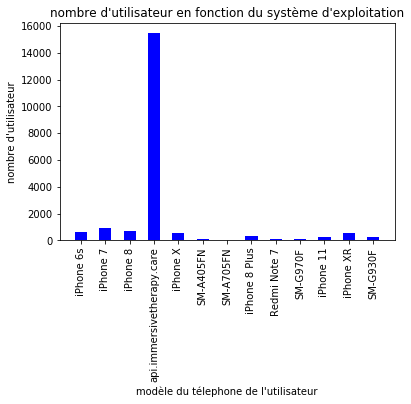

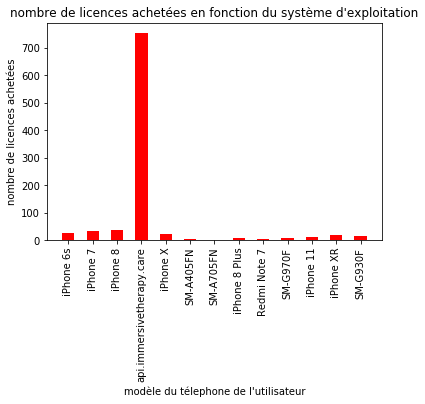

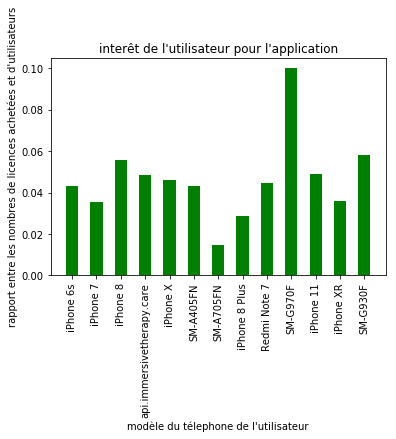

In [11]:
elem_modele = ['iPhone 6s' , 'iPhone 7' , 'iPhone 8', 'api.immersivetherapy.care' , 'iPhone X' , 'SM-A405FN' , 'SM-A705FN' , 'iPhone 8 Plus' , 'Redmi Note 7' , 'SM-G970F' , 'iPhone 11', 'iPhone XR', 'SM-G930F']

liste_modele = []
liste_modele_users = []
for e in elem_modele:
    aggregated_licenses_cursor_modele = licenses_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'events',
                'localField': 'user',
                'foreignField': 'user',
                'as': 'events_document'
            }
        },
        {  '$match': { 'events_document.os.model' : e }  }  ] ) 
    list_res_modele = list(aggregated_licenses_cursor_modele)
    liste_modele.append(len(list_res_modele)) 
    
    aggregated_licenses_cursor_modele_users = users_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'events',
                'localField': '_id',
                'foreignField': 'user',
                'as': 'events_document'
            }
        },
        {  '$match': { 'events_document.os.model'  : e }  }  ] ) 
    list_res_modele_users = list(aggregated_licenses_cursor_modele_users)
    liste_modele_users.append(len(list_res_modele_users))
    


rapport_modele = [0]*(len(liste_modele))
for i in range(len(liste_modele)):
    rapport_modele[i] = liste_modele[i]/liste_modele_users[i]


width = 0.5
plt.figure()
plt.bar(elem_modele, liste_modele_users , width, color='b' )
plt.xticks(rotation = 'vertical')
plt.title("nombre d'utilisateur en fonction du système d'exploitation")
plt.xlabel("modèle du télephone de l'utilisateur")
plt.ylabel("nombre d'utilisateur")
plt.show()

plt.bar(elem_modele, liste_modele , width, color='r' )
plt.xticks(rotation = 'vertical')
plt.title("nombre de licences achetées en fonction du système d'exploitation")
plt.xlabel("modèle du télephone de l'utilisateur")
plt.ylabel("nombre de licences achetées")
plt.show()

plt.title("interêt de l'utilisateur pour l'application")
plt.xlabel("modèle du télephone de l'utilisateur")
plt.ylabel("rapport entre les nombres de licences achetées et d'utilisateurs")
plt.bar(elem_modele, rapport_modele , width, color='g' )
plt.xticks(rotation = 'vertical')
plt.show()

On ne peut pas tirer de réelles conclusions à partir de ces données. Nous avons alors pensé qu'il serait peut-être judicieux de s'intéresser non pas au modèle du téléphone mais au prix de celui-ci. En effet, nous avons pensé que cette information nous permettrait peut-être de nous faire une idée sur l'influence de la situation financière de l'utilisateur sur son achat ou non de licence. 

### Prix du téléphone

Pour pouvoir utiliser la donnée prix du téléphone, il a fallu ajouter celle-ci à notre base de données. Pour ce faire nous avons recenser une soixantaine de modèles puis chercher leur prix en ligne. Enfin nous les avons ajouter à la base de données. Nous vous avons fait parvenir pendant la semaine le code permettant de modifier la base de données. Si il y a un problème nous pouvons à nouveau vous l'envoyer. 

In [15]:
liste_prix = range(0,1600,100)
n = len(liste_prix)

liste_prix1=[]
liste_prix_users = []
for i in range (n-1):


    aggregated_licenses_cursor_prix = licenses_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'events',
                'localField': 'user',
                'foreignField': 'user',
                'as': 'events_document'
            }
        },
        {  '$match': {'events_document.os.prix':{'$gte': liste_prix[i], 
            '$lte': liste_prix[i+1]  } } } ] ) 
    list_res_prix = list(aggregated_licenses_cursor_prix)
    liste_prix1.append(len(list_res_prix)) 
    
    aggregated_licenses_cursor_prix_users = users_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'events',
                'localField': '_id',
                'foreignField': 'user',
                'as': 'events_document'
            }
        },
        {  '$match': {'events_document.os.prix':{'$gte': liste_prix[i], 
            '$lte': liste_prix[i+1] } } } ] ) 

 

    list_res_prix_users = list(aggregated_licenses_cursor_prix_users)
    liste_prix_users.append(len(list_res_prix_users))
   





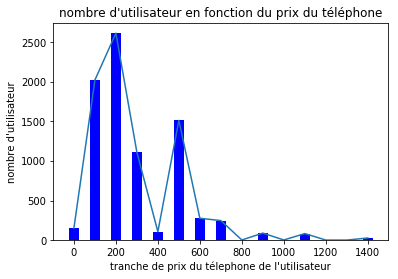

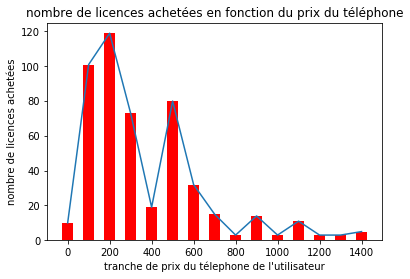

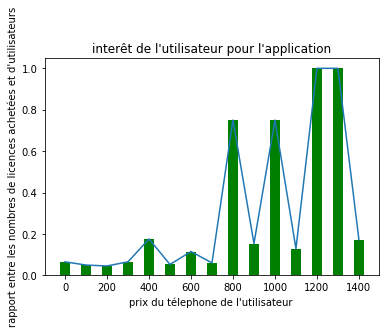

In [16]:
# obtention des courbes

liste_prix1 = [10 , 101 , 119 , 73 , 19 , 80 , 32 , 15 , 3 , 14 , 3 , 11 , 3 , 3 , 5]
liste_prix_users = [153 , 2023 , 2614 , 1111 , 108 , 1514 , 278 , 249 , 4 , 91 , 4 , 85 , 3 , 3 , 29]

rapport_prix = [0]*(len(liste_prix1))
for i in range(len(liste_prix1)):
    rapport_prix[i] = liste_prix1[i]/liste_prix_users[i]


elements = [0 , 100 , 200 , 300 , 400, 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400]
width = 50
plt.figure()
plt.bar(elements, liste_prix_users , width, color='b' )
plt.title("nombre d'utilisateur en fonction du prix du téléphone")
plt.xlabel("tranche de prix du télephone de l'utilisateur")
plt.ylabel("nombre d'utilisateur")
plt.plot(elements, liste_prix_users)
plt.show()

plt.bar(elements, liste_prix1 , width, color='r' )
plt.title("nombre de licences achetées en fonction du prix du téléphone")
plt.xlabel("tranche de prix du télephone de l'utilisateur")
plt.ylabel("nombre de licences achetées")
plt.plot(elements, liste_prix1)
plt.show()

plt.title("interêt de l'utilisateur pour l'application")
plt.xlabel("prix du télephone de l'utilisateur ")
plt.ylabel("rapport entre les nombres de licences achetées et d'utilisateurs")
plt.bar(elements, rapport_prix , width, color='g' )
plt.plot(elements, rapport_prix)
plt.show()

 On constate que la plupart des utilisateurs possèdent des téléphones coûtant aux alentours de 200€. Cependant, le taux de conversion est plus important pour les téléphones les plus coûteux (aussi car il y en a moins). 
Le prix du téléphone reste un paramètre intéressant que nous allons donc chercher à exploiter par la suite.

### 3. Système d'exploitation 

Désormais on s'intéresse au système d'exploitation du téléphone. En effet, il pourrait y avoir des différences entre IOS et Android. 

In [3]:
elem_tel = ['IOS' , 'ANDROID' , 'BACKEND']

liste_tel = []
liste_tel_users = []
for e in elem_tel:
    aggregated_licenses_cursor_tel = licenses_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'events',
                'localField': 'user',
                'foreignField': 'user',
                'as': 'events_document'
            }
        },
        {  '$match': { 'events_document.os.type' : e }  }  ] ) 
    list_res_tel = list(aggregated_licenses_cursor_tel)

    liste_tel.append(len(list_res_tel)) 
    
    aggregated_licenses_cursor_tel_users = users_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'events',
                'localField': '_id',
                'foreignField': 'user',
                'as': 'events_document'
            }
        },
        {  '$match': { 'events_document.os.type'  : e }  }  ] ) 

    list_res_tel_users = list(aggregated_licenses_cursor_tel_users)
    liste_tel_users.append(len(list_res_tel_users))

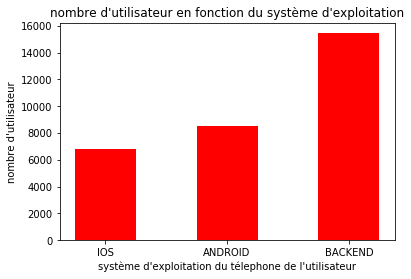

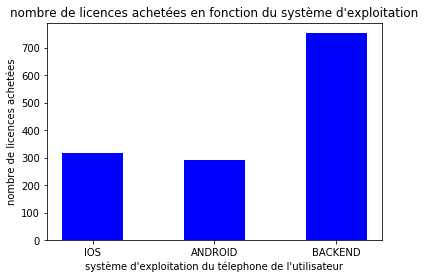

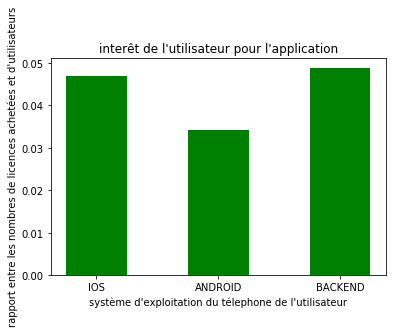

In [4]:
rapport = [0]*3
for i in range(3):
    rapport[i] = liste_tel[i]/liste_tel_users[i]

width = 0.5
plt.figure()

plt.title("nombre d'utilisateur en fonction du système d'exploitation")
plt.xlabel("système d'exploitation du télephone de l'utilisateur")
plt.ylabel("nombre d'utilisateur")
plt.bar(elem_tel, liste_tel_users , width, color='r' )
plt.show()

plt.title("nombre de licences achetées en fonction du système d'exploitation")
plt.xlabel("système d'exploitation du télephone de l'utilisateur")
plt.ylabel("nombre de licences achetées")
plt.bar(elem_tel, liste_tel , width, color='b' )
plt.show()

plt.title("interêt de l'utilisateur pour l'application")
plt.xlabel("système d'exploitation du télephone de l'utilisateur")
plt.ylabel("rapport entre les nombres de licences achetées et d'utilisateurs")
plt.bar(elem_tel, rapport , width, color='g' )
plt.show()

On observe un paramètre "BackEnd". Ce paramètre correspond à des utilisateurs qui passent par internet et non pas par l'application. 
Si le taux de conversion est aussi important sur internet c'est que sur internet les utilisateurs ne peuvent qu'acheter la licence contrairement à l'application où il y a possibilité pour un utilisateurs de lire des cartouches. 
En outre, on remarque que les utilisateurs sous ios achètent plus de licenses.

## 3. Langue et origine de l'utilisateur

Nous avons étudié la langue du téléphone et le pays des utilisateurs. Nous cherchions à déterminer si il y avait des acheteurs étrangers et si cela avait un impact sur leur achat d'une license. 
Il faut rappeler que diapason est une application française, et dont la communication a été faite seulement en France. 

In [5]:
elem = ['fr-FR', 'fr-BE', 'fr-CA', 'fr-CH', 'en-US', 'en-GB','fr-MA', 'fr-US', 'de-DE', 'en-FR', 'ro-RO' ]
liste_lang = []
liste_lang_users = []
for e in elem:
    aggregated_licenses_cursor = licenses_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'events',
                'localField': 'user',
                'foreignField': 'user',
                'as': 'events_document'
            }
        },
        {  '$match': { 'events_document.language' : e }  }  ] ) 
    list_res = list(aggregated_licenses_cursor)
    liste_lang.append(len(list_res))
    
    
    aggregated_licenses_cursor_users = users_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'events',
                'localField': '_id',
                'foreignField': 'user',
                'as': 'events_document'
            }
        },
        {  '$match': { 'events_document.language' : e }  }  ] ) 
    list_res_users = list(aggregated_licenses_cursor_users)
    liste_lang_users.append(len(list_res_users))

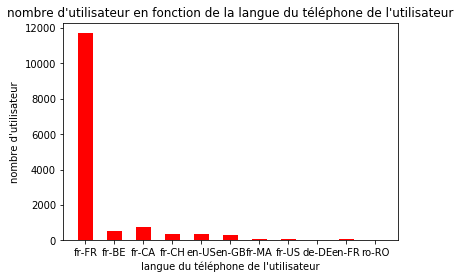

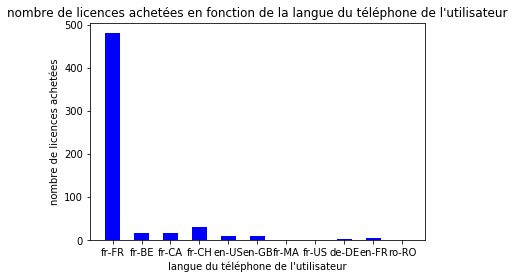

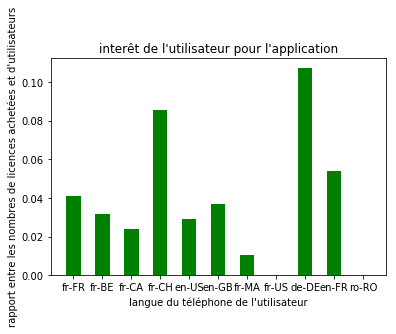

In [6]:
n = len(liste_lang)
liste = [0]*n
for i in range (n):
    liste[i] = liste_lang[i]/liste_lang_users[i]

width = 0.5
plt.figure()

plt.bar(elem, liste_lang_users , width, color='r' )
plt.title("nombre d'utilisateur en fonction de la langue du téléphone de l'utilisateur")
plt.xlabel("langue du téléphone de l'utilisateur")
plt.ylabel("nombre d'utilisateur")
plt.show()

plt.title("nombre de licences achetées en fonction de la langue du téléphone de l'utilisateur")
plt.xlabel("langue du téléphone de l'utilisateur")
plt.ylabel('nombre de licences achetées')
plt.bar(elem, liste_lang , width, color='b' )
plt.show()

plt.title("interêt de l'utilisateur pour l'application")
plt.xlabel("langue du téléphone de l'utilisateur")
plt.ylabel("rapport entre les nombres de licences achetées et d'utilisateurs")
plt.bar(elem, liste , width, color='g' )
plt.show()

On peut conclure de ces graphes que pour fr-CH (Suisse) , en-GB (Grande Bretagne en anglais) et en-US (US en anglais) où il y a environ le même nombre d'utilisateurs de l'application, les utilisateurs de Suisse sont très receptif à l'application et ont environ 4 fois plus tendance à acheter une licence qu'en Angleterre.

D'autre part, en ne comparant pas les nombres d'utilisateurs, les utilisateurs d'Allemagne et de Suisse sont les plus aptes à acheter une licence.
On se rend compte qu'à l'étranger il y a peu d'utilisateurs mais que ceux-ci achètent plus facilement la licence. En effet, la publicité ayant été faite en France les utilisateurs étrangers viennent spécifiquement sur l'application pour acheter la license. On peut alors se dire que l'étranger est un marché tout aussi intéressant que la France. 

## 4. Etude des acouphènes et des activités faites

### 1. Objectif du partient

530
530
64
64
28
28
27
27
[530, 64, 28, 27]
[12684, 1827, 659, 454]


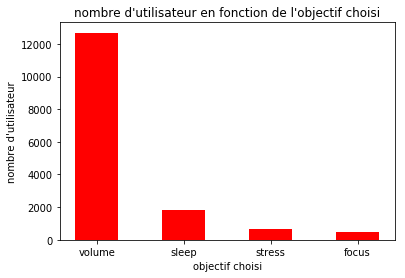

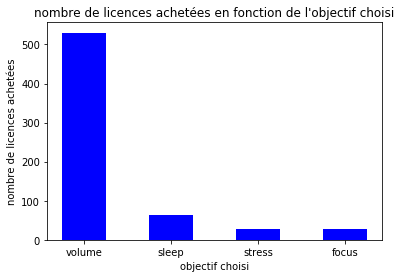

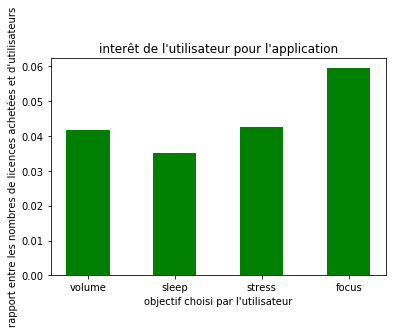

In [9]:
elem_objectifs = ['volume' , 'sleep', 'stress','focus']
liste_tel = []
liste_tel_users = []
for e in elem_objectifs:
    aggregated_licenses_cursor_tel = licenses_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'events',
                'localField': 'user',
                'foreignField': 'user',
                'as': 'events_document'
            }
        },
        {  '$match': { 'events_document.data.goal' : e }  }  ] ) 
    list_res_tel = list(aggregated_licenses_cursor_tel)
    print(len(list_res_tel))
    liste_tel.append(len(list_res_tel)) 
    
    aggregated_licenses_cursor_tel_users = users_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'events',
                'localField': '_id',
                'foreignField': 'user',
                'as': 'events_document'
            }
        },
        {  '$match': { 'events_document.data.goal'  : e }  }  ] ) 
    print(len(list_res_tel))
    list_res_tel_users = list(aggregated_licenses_cursor_tel_users)
    liste_tel_users.append(len(list_res_tel_users))
    
print(liste_tel)
print(liste_tel_users)

rapport = [0]*4
for i in range(4):
    rapport[i] = liste_tel[i]/liste_tel_users[i]

width = 0.5
plt.figure()

plt.title("nombre d'utilisateur en fonction de l'objectif choisi")
plt.xlabel("objectif choisi")
plt.ylabel("nombre d'utilisateur")
plt.bar(elem_objectifs, liste_tel_users , width, color='r' )
plt.show()

plt.title("nombre de licences achetées en fonction de l'objectif choisi")
plt.xlabel("objectif choisi")
plt.ylabel("nombre de licences achetées")
plt.bar(elem_objectifs, liste_tel , width, color='b' )
plt.show()

plt.title("interêt de l'utilisateur pour l'application")
plt.xlabel("objectif choisi par l'utilisateur")
plt.ylabel("rapport entre les nombres de licences achetées et d'utilisateurs")
plt.bar(elem_objectifs, rapport , width, color='g' )
plt.show()

### 2. Score wfu

Le score wfu correspond au score d'une évaluation permettant de décrire le niveau de gravité de l'acouphène. Nous avons donc jugé intéressant d'étudier ce paramètre, plus précisément d'étudier le score wfu lors de la première utilisation des utilisateurs dans le but de le comparer avec celui des futurs licenciés. 

In [40]:
donnee_scorewfu=events_collection.aggregate(pipeline=[
    {'$match':{
        'type':'ACTIVITY_COMPLETE',
        'data.activity':'evaluation',
        'data.name':'wfu'}},
    {'$group':
    {'_id':'$user',
    'Datemin':{'$min':'$date'},
    'score':{'$first':'data.score'}}}   
])
listewfu=list(donnee_scorewfu)

In [55]:
liste_score=[]
for i in range(len(listewfu)):
    liste_score.append(listewfu[i]['score'][j])


In [72]:
donnee_scorewful=licenses_collection.aggregate(pipeline=[
    {'$lookup':{'from':'events',
                'localField':'user',
                'foreignField':'user',
                'as':'events_document'
        
    }},
    {'$match':{
        'events_document.type':'ACTIVITY_COMPLETE',
        'events_document.data.activity':'evaluation',
        'events_document.data.name':'wfu'}},
    {'$group':{'_id':'$user',
              'Datemin':{'$min':'$events_document.date'},
              'score':{'$first':'events_document.data.score'}}}
])
listewful=list(donnee_scorewfu)



In [73]:
liste_score2=[]
def minimumIndices(liste):
    mini = liste[0]
    longueur=len(liste)
    for i in range(longueur):
        if liste[i]<= mini:
            mini = i
    return mini

for i in range(len(listewful)):
    j=minimumIndices(listewful[i]['Datemin'])
    liste_score2.append(listewful[i]['score'][j])
print(liste_score2)

[]


(array([    0.,     0.,     0.,     0.,     0., 10232.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

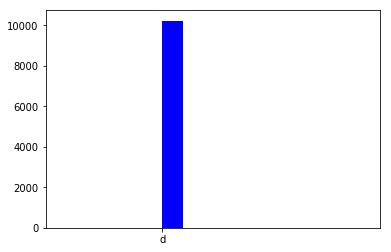

In [62]:
plt.hist(liste_score2,color='red') 
plt.hist(liste_score,color='blue')

# II. Catégorisation

Notre objectif initial est de crééer des profils d'acheteur. Pour cela nous avons pensé à regrouper les utilisateurs licenciés selon certains critères. Nous avons d'abord jugé judicieux de comparer les critères numériques que nous avions utilisé précédemment: l'âge, le score wfu et le prix de leur téléphone. 

## 1. Etude préliminaire

Pour cibler les critères que nous voulions utiliser, nous avons réaliser une analyse en composante principale. Nous cherchions des corrélations entre ces données, ou alors quelle donnée était la plus importante. 

1989


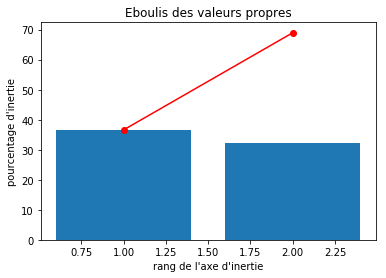

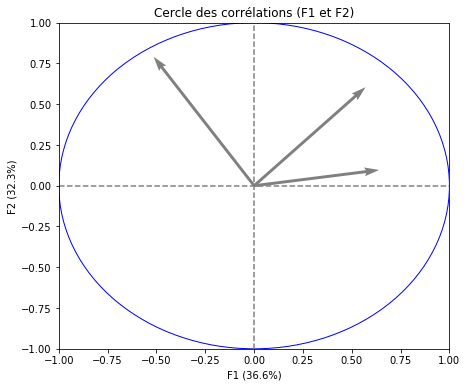

NameError: name 'features' is not defined

In [8]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:],
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))

            # affichage des noms des variables
            if labels is not None:
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(7,6))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

## Fin

import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing


# choix du nombre de composantes à calculer
n_comp = 2

donnees_age=events_collection.aggregate(pipeline=[
    {'$lookup':{
        'from':'users',
        'localField':'user',
        'foreignField':'_id',
        'as':'users_document'
    }},

    {'$match':
    {'type':'ACTIVITY_COMPLETE',
    'data.activity':'evaluation',
    'data.name':'wfu',
    'users_document.birthDate':{'$not':{'$eq':None}},
    'os.prix':{'$not':{'$eq':None}}}},

    {'$group':{
        '_id':'$user',
        'Datemin':{'$min':'$date'},
        'score':{'$first':'$data.score'},
        'prix':{'$first':'$os.prix'},
        'age':{'$first':'$users_document.birthDate'}

    }
    }

])

liste2=list(donnees_age)

listedonnees2=[]
liste_score2=[]
liste_age=[]
liste_prix=[]

print(liste2[0]['age'][0].year)
for i in range (len(liste2)):
    if liste2[i]['age']!=[] and liste2[i]['age'][0].year!=1965:
        listedonnees2.append([liste2[i]['score'],2020-liste2[i]['age'][0].year,liste2[i]['prix']])
        liste_score2.append(liste2[i]['score'])
        liste_age.append(liste2[i]['age'][0].year)

X=np.array(listedonnees2)
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)])
display_circles(pcs, n_comp, pca, [(0,1)], lims=[.0155, .019, 0.053, .057], labels = np.array(features))
display_circles(pcs, n_comp, pca, [(2,3)], lims=[-.035, -.026, -.03,-.016], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], illustrative_var = theme, alpha = 0.5)

plt.show()


Cette ACP nous permet de conclure deux choses. La première est qu'aucune des trois variables a un poids suffisamment important pour être considérée comme "principale". En effet l'énergie est de l'ordre de 36% ce qui est très proche de la valeur "minimale" de 33%. La seconde est qu'on observe que l'âge et le prix du téléphone sont décorrelés comme les deux flèches sont orthogonales. 
Ces remarques nous ont permis de comprendre que notre volonté de réaliser un "clustering" sur ces paramètres. Cependant, nous n'avons compris ça que plus tard nous avions déjà coder différents clustering. 

In [34]:
donnees_age=events_collection.aggregate(pipeline=[
    {'$lookup':{
        'from':'users',
        'localField':'user',
        'foreignField':'_id',
        'as':'users_document'
    }},

    {'$match':
    {'type':'ACTIVITY_COMPLETE',
    'data.activity':'evaluation',
    'data.name':'wfu',
    'users_document.birthDate':{'$not':{'$eq':None}}}},
    
    {'$group':{
        '_id':'$user',
        'Datemin':{'$min':'$date'},
        'score':{'$first':'$data.score'},
        'age':{'$first':'$users_document.birthDate'}
     
    }
    }
    
])
liste2=list(donnees_age)

In [35]:
listedonnees2=[]
liste_score2=[]
liste_age=[]


for i in range (len(liste2)):
    if liste2[i]['age']!=[] and liste2[i]['age'][0].year!=1965:
        listedonnees2.append([liste2[i]['_id'],liste2[i]['score'],2020-liste2[i]['age'][0].year])
        liste_score2.append(liste2[i]['score'])
        liste_age.append(liste2[i]['age'][0].year)

 
ms2=stat.mean(liste_score2)
ma=stat.mean(liste_age)
es2=stat.stdev(liste_score2)
ea=(stat.stdev(liste_age))

<function matplotlib.pyplot.show(*args, **kw)>

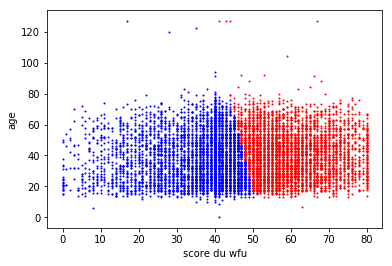

In [36]:
ensemble_point=[[listedonnees2[i][1],listedonnees2[i][2]] for i in range (len(listedonnees2))]
cluster1=range(0,int(len(ensemble_point)/2))
cluster2=range(int(len(ensemble_point)/2)+1,len(ensemble_point))
def centroide(points,cluster):
    n=len(cluster)
    sx=0
    sy=0
    for i in cluster:
        sx+=points[i][0]
        sy+=points[i][1]
    return(sx/n,sy/n)

def distance(x,y):
    return(np.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2))
def W(cluster,points,centroide):
    s=0
    for i in cluster:
        s+=(points[i][0]-centroide[0])**2+(points[i][1]-centroide[1])**2
    return(s)
def clustering(ensemble_point,cluster1,cluster2):
    centroide1x,centroide1y= centroide(ensemble_point,cluster1)
    centroide2x,centroide2y= centroide(ensemble_point,cluster2)
    Wt=W(cluster1,ensemble_point,[centroide1x,centroide1y])+W(cluster2,ensemble_point,[centroide2x,centroide2y])
    newcluster1=[]
    newcluster2=[]
    k=1
    for i in range(len(ensemble_point)):
        if distance(ensemble_point[i],[centroide1x,centroide1y])>distance(ensemble_point[i],[centroide2x,centroide2y]):
            newcluster2.append(i)
        else:
            newcluster1.append(i)
    newcentroide1x,newcentroide1y=centroide(ensemble_point,newcluster1)
    newcentroide2x,newcentroide2y=centroide(ensemble_point,newcluster2)
    Wt2=W(newcluster1,ensemble_point,[newcentroide1x,newcentroide1y])+W(newcluster2,ensemble_point,[newcentroide2x,newcentroide2y])
    while abs(Wt2-Wt)>0:
        k+=1
        Wt=Wt2
        newcluster1=[]
        newcluster2=[]
        for i in range(len(ensemble_point)):
            if distance(ensemble_point[i],[newcentroide1x,newcentroide1y])>distance(ensemble_point[i],[newcentroide2x,newcentroide2y]):
                newcluster2.append(i)
            else:
                newcluster1.append(i)
        newcentroide1x,newcentroide1y=centroide(ensemble_point,newcluster1)
        newcentroide2x,newcentroide2y=centroide(ensemble_point,newcluster2)
        Wt2=W(newcluster1,ensemble_point,[newcentroide1x,newcentroide1y])+W(newcluster2,ensemble_point,[newcentroide2x,newcentroide2y])

    return(newcluster1,newcluster2)

cluster1f,cluster2f=clustering(ensemble_point,cluster1,cluster2)
cluster1_x=[listedonnees2[i][1] for i in cluster1f]
cluster1_y=[listedonnees2[i][2] for i in cluster1f]
cluster2_x=[listedonnees2[i][1] for i in cluster2f]
cluster2_y=[listedonnees2[i][2] for i in cluster2f]
plt.scatter(cluster1_x,cluster1_y,color='red',s=1)
plt.scatter(cluster2_x,cluster2_y,color='blue',s=1)
plt.xlabel('score du wfu')
plt.ylabel('age')
plt.show

Nous nous sommes rendus compte que ce clustering n'avait pas grand intérêt car l'univers était "continu". On obtient un bloc uniforme et non plusieurs petits groupes assez distincts. On en a conclu que le clustering ici n'était pas intéressant. 
Nous avons alors décidé de visualiser les données pour chercher où étaient les données intéressantes à exploiter. Pour cela nous avons visualisé des données sur le prix et le scofe wfu. 

In [37]:
donnees_age=events_collection.aggregate(pipeline=[
    {'$lookup':{
        'from':'users',
        'localField':'user',
        'foreignField':'_id',
        'as':'users_document'
    }},

    {'$match':
    {'type':'ACTIVITY_COMPLETE',
    'data.activity':'evaluation',
    'data.name':'wfu',
    'os.prix':{'$not':{'$eq':None}}}
},
    
    {'$group':{
        '_id':'$user',
        'Datemin':{'$min':'$date'},
        'prix':{'$first':'$os.prix'},
        'score':{'$first':'$data.score'}

     
    }
    }
])
liste=list(donnees_age)
prix=[]
score=[]
for i in range (len(liste)):
    prix.append(liste[i]['prix'])
    score.append(liste[i]['score'])

In [38]:
donnees_agelicenses=licenses_collection.aggregate(pipeline=[
    {'$lookup':{
        'from':'events',
        'localField':'user',
        'foreignField':'user',
        'as':'events_document'
    }},
    {'$lookup':{
        'from':'users',
        'localField':'user',
        'foreignField':'_id',
        'as':'users_document'
    }},

    {'$match':
    {'events_document.type':'ACTIVITY_COMPLETE',
    'events_document.data.activity':'evaluation',
    'events_document.data.name':'wfu',
    'users_document.birthDate':{'$not':{'$eq':None}}}},
    
    {'$group':{
        '_id':'$user',
        'Datemin':{'$min':'$events_document.date'},
        'score':{'$first':'$events_document.data.score'},
        'prix':{'$first':'$events_document.os.prix'},
        'age':{'$first':'$users_document.birthDate'}
     
    }
    }
    
])
listelicenses=list(donnees_agelicenses)
def minimumIndices(liste):
    mini = liste[0]
    longueur=len(liste)
    for i in range(longueur):
        if liste[i]<= mini:
            mini = i
    return mini
score2=[]
prix2=[]
for i in range (len(listelicenses)):
    j= minimumIndices(listelicenses[i]['Datemin'])
    if listelicenses[i]['prix']!=[]:
        score2.append(listelicenses[i]['score'][j])
        prix2.append(listelicenses[i]['prix'][0])

Text(0,0.5,'prix du téléphone')

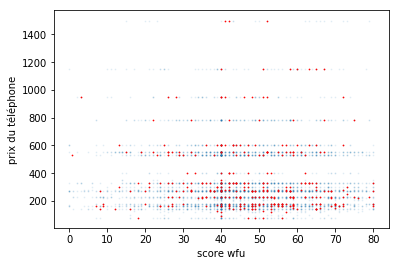

In [39]:
plt.scatter(score,prix,s=0.5,alpha=0.1)
plt.scatter(score2,prix2,s=0.5,color='red')
plt.xlabel('score wfu')
plt.ylabel('prix du téléphone')

Ce qu'on peut observer sur ces données c'est que les licensiés sont majoritairement regrouper autour d'un score wfu de 50-60 et un téléphone coûtant entre 200-400€. Cette observation nous permet alors de regrouper les utilisateurs licenciés selon un petit groupe. 

# Conclusion

Pour conclure, nous avons pu observer de nombreux paramètres différents dans le but de déterminer lesquels jouaient en rôle dans l'achat ou non d'une license. 
Parmi ces paramètres il y a l'âge des utilisateurs, le prix de leur téléphone, la langue de leur téléphone, le type de système d'exploitation... Toutes ces études nous ont permis de dresser un premier portrait des potentiels acheteurs et de souligner quelle population pouvait être intéressée par acheter une licence de l'application. 
Nous avons voulu aller plus loin en mettant en lien certains de ces paramètres. Cependant nous nous sommes rendus compte que certains de ces paramètres étaient loin d'être correlés et donc difficile d'exploiter ensemble.

Enfin, l'application diapason est une application très utiles pour les personnes souffrant d'acouphènes. Il est vrai que l'achat d'une licence est un achat conséquent, mais c'est aussi un moyen ludique et pratique de se soigner n'importe où et n'importe quand. Ce genre de praticité est de plus en plus recherchée de nos jours et l'application semble donc dans la continuité de l'évolution actuelle de nos jours. C'est pourquoi il est très intéressant de cibler de potentiels patients et acheteurs d'une telle application. 



### Petit mot pour les encadrants 

Nous vous remercions pour l'aide que vous nous avez apporté toute la semaine, vous avez été très à l'écoute, nous avez conseillé et aiguillé. Nous avons pu apprendre beaucoup de choses sur le traitement de données. Nous avons beaucoup aimé travailler avec vous et espérons que notre travail vous sera utile. 
Nous vous souhaitons une bonne continuation avec diapason. 

Ce travail a été réalisé par: Thomas Josse - Marie Salczer - Thomas Buscaylet - Emma Scharfmann - Iona Serquin